In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Build a custom CNN composed of 5 convolutional layers with ReLU activation between all the five layers and a fully-connected output layer.

class FashionMNIST_ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 0)
        self.conv4 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0)
        self.conv5 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0)
        self.fc = torch.nn.Linear(128 * 7 * 7, 10)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x
    

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = [], [], [], []

    # Create a plot with labeled axes
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        val_loss /= len(test_loader)
        val_accuracy = 100 * correct / total
        print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
        print(f'Validation Accuracy = {val_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        test_loss_hist.append(val_loss)
        test_acc_hist.append(val_accuracy)


    # Plot the training loss over epochs
    plt.plot(train_loss_hist, label='Training Loss')
    plt.plot(test_loss_hist, label='Validation Loss')
    plt.legend()
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")
    print()
    print(f"Cross-Entropy on validation set: {test_loss_hist[-1]:.4f}")
    print(f"Accuracy on validation set:      {test_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

In [3]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = transform, download = True)

batch_size = 2048

TrainLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
TestLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [4]:
# Initialize the network, loss function, and optimizer
device = set_device()
ConvNet = FashionMNIST_ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr = 0.01)

Device: mps


Epoch 1/16
======== Training phase ========


Loss = 0.6342  |  Accuracy = 52.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Training Cross-Entropy Loss = 1.3639
Training Accuracy = 52.30%
======== Validation phase ========


Loss = 0.6608  |  Accuracy = 73.37% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.25it/s]


Validation Cross-Entropy Loss = 0.6943
Validation Accuracy = 73.37%

Epoch 2/16
======== Training phase ========


Loss = 0.3949  |  Accuracy = 77.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


Training Cross-Entropy Loss = 0.5779
Training Accuracy = 77.65%
======== Validation phase ========


Loss = 0.5195  |  Accuracy = 79.62% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Validation Cross-Entropy Loss = 0.5281
Validation Accuracy = 79.62%

Epoch 3/16
======== Training phase ========


Loss = 0.3668  |  Accuracy = 82.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.12it/s]


Training Cross-Entropy Loss = 0.4560
Training Accuracy = 82.93%
======== Validation phase ========


Loss = 0.4773  |  Accuracy = 82.23% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.61it/s]


Validation Cross-Entropy Loss = 0.4837
Validation Accuracy = 82.23%

Epoch 4/16
======== Training phase ========


Loss = 0.3705  |  Accuracy = 85.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.3867
Training Accuracy = 85.71%
======== Validation phase ========


Loss = 0.3655  |  Accuracy = 86.31% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Validation Cross-Entropy Loss = 0.3769
Validation Accuracy = 86.31%

Epoch 5/16
======== Training phase ========


Loss = 0.3443  |  Accuracy = 87.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


Training Cross-Entropy Loss = 0.3374
Training Accuracy = 87.57%
======== Validation phase ========


Loss = 0.3562  |  Accuracy = 86.30% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.32it/s]


Validation Cross-Entropy Loss = 0.3717
Validation Accuracy = 86.30%

Epoch 6/16
======== Training phase ========


Loss = 0.2862  |  Accuracy = 88.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.27it/s]


Training Cross-Entropy Loss = 0.3163
Training Accuracy = 88.34%
======== Validation phase ========


Loss = 0.3158  |  Accuracy = 87.61% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


Validation Cross-Entropy Loss = 0.3410
Validation Accuracy = 87.61%

Epoch 7/16
======== Training phase ========


Loss = 0.2472  |  Accuracy = 89.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


Training Cross-Entropy Loss = 0.2945
Training Accuracy = 89.11%
======== Validation phase ========


Loss = 0.2896  |  Accuracy = 88.44% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.60it/s]


Validation Cross-Entropy Loss = 0.3110
Validation Accuracy = 88.44%

Epoch 8/16
======== Training phase ========


Loss = 0.2454  |  Accuracy = 89.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.09it/s]


Training Cross-Entropy Loss = 0.2747
Training Accuracy = 89.92%
======== Validation phase ========


Loss = 0.3001  |  Accuracy = 88.34% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.62it/s]


Validation Cross-Entropy Loss = 0.3204
Validation Accuracy = 88.34%

Epoch 9/16
======== Training phase ========


Loss = 0.2944  |  Accuracy = 89.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


Training Cross-Entropy Loss = 0.2752
Training Accuracy = 89.90%
======== Validation phase ========


Loss = 0.2765  |  Accuracy = 89.25% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]


Validation Cross-Entropy Loss = 0.2987
Validation Accuracy = 89.25%

Epoch 10/16
======== Training phase ========


Loss = 0.2888  |  Accuracy = 90.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.37it/s]


Training Cross-Entropy Loss = 0.2606
Training Accuracy = 90.47%
======== Validation phase ========


Loss = 0.2609  |  Accuracy = 89.34% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.39it/s]


Validation Cross-Entropy Loss = 0.2873
Validation Accuracy = 89.34%

Epoch 11/16
======== Training phase ========


Loss = 0.2469  |  Accuracy = 91.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


Training Cross-Entropy Loss = 0.2439
Training Accuracy = 91.00%
======== Validation phase ========


Loss = 0.2680  |  Accuracy = 89.58% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.63it/s]


Validation Cross-Entropy Loss = 0.2912
Validation Accuracy = 89.58%

Epoch 12/16
======== Training phase ========


Loss = 0.2079  |  Accuracy = 91.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.21it/s]


Training Cross-Entropy Loss = 0.2352
Training Accuracy = 91.36%
======== Validation phase ========


Loss = 0.2714  |  Accuracy = 89.51% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


Validation Cross-Entropy Loss = 0.2957
Validation Accuracy = 89.51%

Epoch 13/16
======== Training phase ========


Loss = 0.1944  |  Accuracy = 91.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


Training Cross-Entropy Loss = 0.2205
Training Accuracy = 91.89%
======== Validation phase ========


Loss = 0.2719  |  Accuracy = 89.40% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.60it/s]


Validation Cross-Entropy Loss = 0.2981
Validation Accuracy = 89.40%

Epoch 14/16
======== Training phase ========


Loss = 0.2082  |  Accuracy = 92.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.12it/s]


Training Cross-Entropy Loss = 0.2168
Training Accuracy = 92.05%
======== Validation phase ========


Loss = 0.2596  |  Accuracy = 89.87% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


Validation Cross-Entropy Loss = 0.2848
Validation Accuracy = 89.87%

Epoch 15/16
======== Training phase ========


Loss = 0.1877  |  Accuracy = 92.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Training Cross-Entropy Loss = 0.2078
Training Accuracy = 92.41%
======== Validation phase ========


Loss = 0.2538  |  Accuracy = 90.36% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]


Validation Cross-Entropy Loss = 0.2791
Validation Accuracy = 90.36%

Epoch 16/16
======== Training phase ========


Loss = 0.2383  |  Accuracy = 92.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.23it/s]


Training Cross-Entropy Loss = 0.2015
Training Accuracy = 92.63%
======== Validation phase ========


Loss = 0.2430  |  Accuracy = 90.47% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


Validation Cross-Entropy Loss = 0.2751
Validation Accuracy = 90.47%



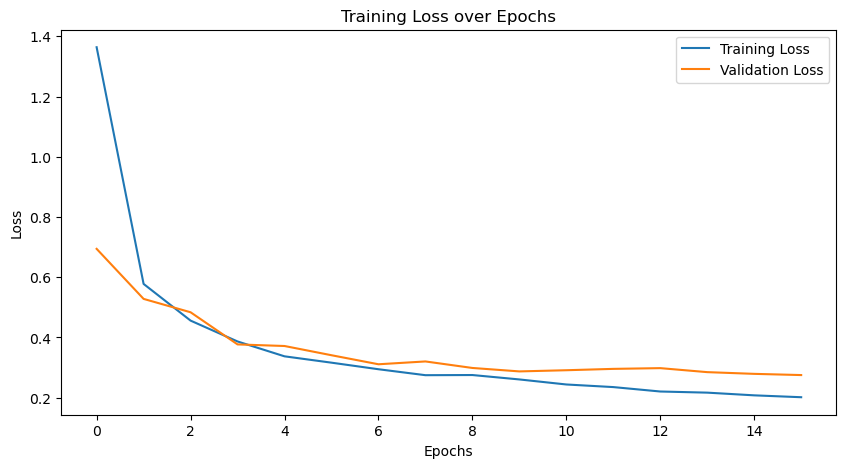

Cross-Entropy on training set:  0.2015
Accuracy on training set:       92.63%

Cross-Entropy on validation set: 0.2751
Accuracy on validation set:      90.47%


In [5]:
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ConvNet, TrainLoader, TestLoader, optimizer, criterion, epochs = 16, device = device)